# hyper parametres tuning
in this file we use keras tuner for hyper parametring our model

## preprocessing
we using mnist dataset for this model

In [1]:
!pip install -q -U keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.4 MB/s eta 0:00:00


In [1]:
import tensorflow as tf
import numpy as np
import keras_tuner as kt
import matplotlib.pyplot as plt
import h5py

(1080, 64, 64, 3)
(120, 64, 64, 3)
(1080,)
(120,)


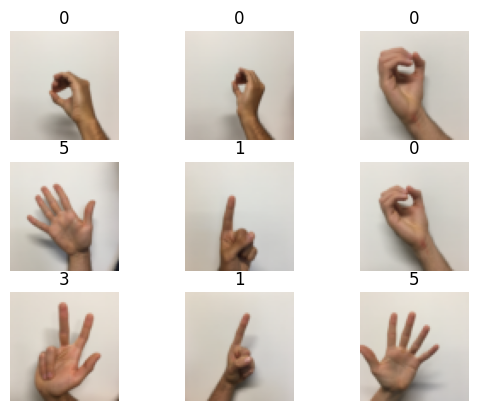

In [2]:
train_set = h5py.File("../datasets/train_signs.h5","r")
test_set = h5py.File("../datasets/test_signs.h5","r")

x_train = np.array(train_set["train_set_x"])
y_train = np.array(train_set["train_set_y"])
x_test = np.array(test_set["test_set_x"])
y_test = np.array(test_set["test_set_y"])
#print("data point species: "+str(x_train.element_spec) , "size of tarin set:"+str(x_train.cardinality().numpy()),"size of test set:"+str(x_test.cardinality().numpy()),sep="\n")
print(x_train.shape , x_test.shape , y_train.shape , y_test.shape , sep="\n")
# iter_x_test = iter(x_test)
# iter_y_test = iter(y_test)
for i in range(9):
    plt.subplot(3,3,i+1)
    # plt.imshow(next(iter_x_test))
    # plt.title(next(iter_y_test).numpy())
    plt.imshow(x_test[i])
    plt.title(y_test[i])
    plt.axis("off")

## hypertuning


In [3]:
def build_model(hp):
  """
  in this function we build and compile a model in order to hyper tunnig it

  arguments:
  hp -- an keras_tuner.HyperParameters object

  return:
  model -- an compiled model
  """
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=[64,64,3]))#)
  num_layers = hp.Int("num_layers",min_value=5,max_value=10,step=1)
  model.add(tf.keras.layers.BatchNormalization())
  for i in range(num_layers):
    #model.add(tf.keras.layers.BatchNormalization())
    hidden_units = hp.Int("hidden_units"+str(i+1),min_value=2,max_value=512,step=2,sampling="log")
    activation = hp.Choice("activation"+str(i+1),["relu","leaky_relu","tanh"])
    model.add(tf.keras.layers.Dense(hidden_units,activation))
    if hp.Boolean("dropout"):
      model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.keras.layers.Dense(6))

  alpha = hp.Float("learning_rate",min_value=0.0001,max_value=1,sampling="log")

  model.compile(
      optimizer = tf.keras.optimizers.Adam(alpha),
      loss =  tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics = ["accuracy"]
  )

  return model

model_test = build_model(kt.HyperParameters())

In [4]:
model_test.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 batch_normalization (Batch  (None, 12288)             49152     
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 2)                 24578     
                                                                 
 dense_1 (Dense)             (None, 2)                 6         
                                                                 
 dense_2 (Dense)             (None, 2)                 6         
                                                                 
 dense_3 (Dense)             (None, 2)                 6         
                                                        

In [ ]:
tuner = kt.BayesianOptimization(
    build_model ,
    objective = "val_loss" ,
    max_trials = 20 ,
)

In [23]:
tuner.search(x_train , y_train , validation_split = 0.2)
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 20 Complete [00h 00m 02s]
val_loss: 2.195641040802002

Best val_loss So Far: 1.789659857749939
Total elapsed time: 00h 03m 01s


In [27]:
best_hps.get("num_layers")

9

In [38]:
model = tuner.hypermodel.build(best_hps)

In [ ]:
model.fit(x_train , y_train , epochs = 100 , validation_data=(x_test,y_test))

In [ ]:
model.summary()

as you can see this performed model doesnt work very well

In [6]:
tuner_7= kt.Hyperband(
    build_model ,
    objective = "val_accuracy",
    max_epochs=50,
    factor = 2,
    directory='my_dir2',
    project_name='intro_to_kt'
)

In [7]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [8]:
tuner_7.search(x_train , y_train , validation_split=0.2,batch_size=32,epochs=200,callbacks=[stop_early])

Trial 105 Complete [00h 00m 08s]
val_accuracy: 0.24074074625968933

Best val_accuracy So Far: 0.7175925970077515
Total elapsed time: 00h 09m 28s

Search: Running Trial #106

Value             |Best Value So Far |Hyperparameter
7                 |9                 |num_layers
8                 |512               |hidden_units1
leaky_relu        |leaky_relu        |activation1
True              |True              |dropout
512               |32                |hidden_units2
tanh              |leaky_relu        |activation2
16                |32                |hidden_units3
tanh              |tanh              |activation3
512               |128               |hidden_units4
relu              |relu              |activation4
4                 |512               |hidden_units5
tanh              |leaky_relu        |activation5
0.00029673        |0.00020851        |learning_rate
128               |256               |hidden_units6
relu              |leaky_relu        |activation6
16            

KeyboardInterrupt: 

In [ ]:
tuner_6.results_summary()

In [99]:
best_hp = tuner_6.get_best_hyperparameters(num_trials=112)[0]

In [100]:
best_hp

In [103]:
model_last = tuner_6.hypermodel.build(best_hp)

In [104]:
best_hp.get("num_layers")

1

In [105]:
model_last.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 12288)             0         
                                                                 
 batch_normalization_3 (Bat  (None, 12288)             49152     
 chNormalization)                                                
                                                                 
 dense_14 (Dense)            (None, 128)               1572992   
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 6)                 774       
                                                                 
Total params: 1622918 (6.19 MB)
Trainable params: 1598342 (6.10 MB)
Non-trainable params: 24576 (96.00 KB)
_____________

In [9]:
def build_model_2(hp):
  """
  in this function we build and compile a model in order to hyper tunnig it

  arguments:
  hp -- an keras_tuner.HyperParameters object

  return:
  model -- an compiled model
  """
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=[64,64,3]))#)
  num_layers = hp.Int("num_layers",min_value=2,max_value=8,step=1)
  model.add(tf.keras.layers.BatchNormalization())
  for i in range(num_layers):
    #model.add(tf.keras.layers.BatchNormalization())
    hidden_units = hp.Int("hidden_units"+str(i+1),min_value=2,max_value=128,step=2,sampling="log")
    #activation = hp.Choice("activation"+str(i+1),["relu","leaky_relu","tanh"])
    model.add(tf.keras.layers.Dense(hidden_units,activation="relu"))


  if hp.Boolean("dropout"):
    model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.keras.layers.Dense(6))

  alpha = hp.Float("learning_rate",min_value=0.0001,max_value=0.1,sampling="log")

  model.compile(
      optimizer = tf.keras.optimizers.Adam(alpha),
      loss =  tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics = ["accuracy"]
  )

  return model

model_test = build_model_2(kt.HyperParameters())

In [10]:
tuner_new_1= kt.Hyperband(
    build_model ,
    objective = "val_accuracy",
    max_epochs=50,
    factor = 2,
    directory='my_dir3',
    project_name='intro_to_kt'
)

In [11]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [13]:
tuner_new_1.search(x_train , y_train , validation_split=0.2,batch_size=32,epochs=50,callbacks=[stop_early])

Trial 73 Complete [00h 00m 09s]
val_accuracy: 0.7453703880310059

Best val_accuracy So Far: 0.7453703880310059
Total elapsed time: 00h 08m 34s

Search: Running Trial #74

Value             |Best Value So Far |Hyperparameter
5                 |6                 |num_layers
32                |64                |hidden_units1
relu              |relu              |activation1
True              |False             |dropout
16                |16                |hidden_units2
leaky_relu        |relu              |activation2
16                |128               |hidden_units3
relu              |leaky_relu        |activation3
32                |256               |hidden_units4
relu              |tanh              |activation4
256               |4                 |hidden_units5
tanh              |tanh              |activation5
0.0015902         |0.00014438        |learning_rate
128               |256               |hidden_units6
tanh              |leaky_relu        |activation6
8                

KeyboardInterrupt: 

In [21]:
# we will use a result from iteration 112 from last hyperp tuning

In [18]:
manual_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dense(16,activation="leaky_relu"),
    tf.keras.layers.Dense(8,activation="relu"),
    tf.keras.layers.Dense(256,activation="tanh"),
    tf.keras.layers.Dense(8,activation="relu"),
    tf.keras.layers.Dense(32,activation="tanh"),
    tf.keras.layers.Dense(256,activation="relu"),
    tf.keras.layers.Dense(4,activation="tanh"),
    tf.keras.layers.Dense(256,activation="leaky_relu"),
    tf.keras.layers.Dense(6)
])

In [19]:
manual_model.compile(
    optimizer = tf.keras.optimizers.Adam(0.0001689),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ["accuracy"]
)

In [ ]:
manual_model.fit(x_train , y_train , epochs = 200 , batch_size = 32 , validation_data = (x_test,y_test))

as you can see we get a  very good result on tset set
before hyper parameters tuning we have 80% accuracy but now we have 95% accuracy